In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Polygon

In [7]:
n_points = 2000
eps = 1e-3
noise_std = 0.2
h = 0.02

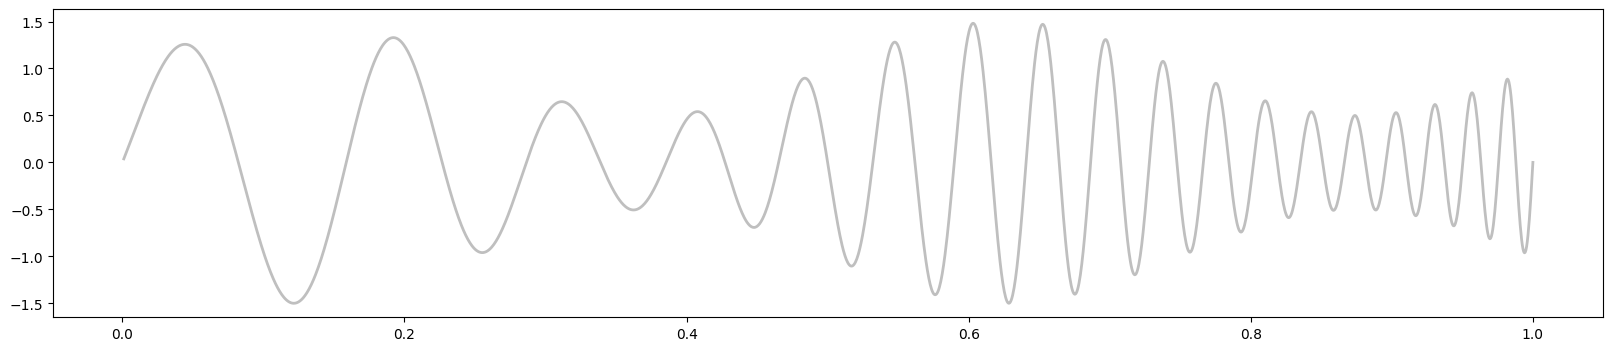

In [10]:
x = np.linspace(eps, 1.0, n_points)
y_clean = (1 + 0.5 * np.sin(4 * np.pi * x)) * np.sin(2 * np.pi * (6 * x + 12 * x**3))

plt.figure(figsize=(20, 4))
plt.plot(x, y_clean, color='gray', linewidth=2, alpha=0.5)
plt.show()

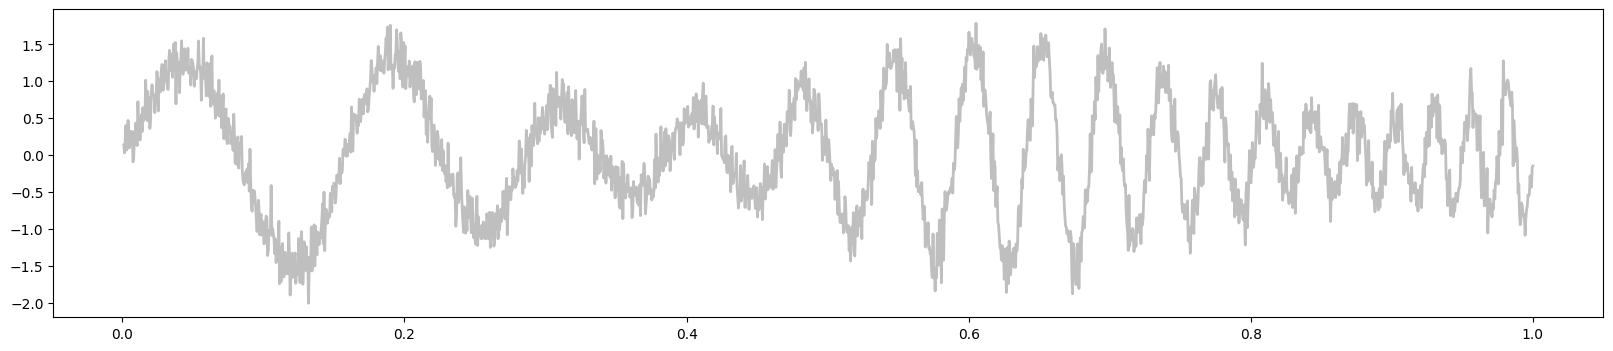

In [11]:
np.random.seed(42)
noise = np.random.normal(scale=noise_std, size=n_points)
y_noisy = y_clean + noise

plt.figure(figsize=(20, 4))
plt.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.5)
plt.show()

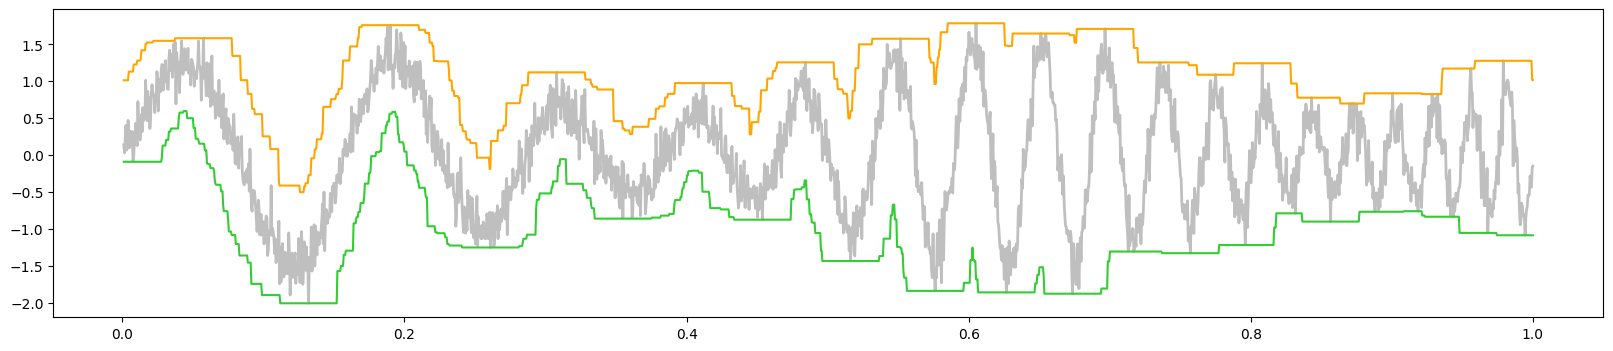

In [16]:
dx = x[1] - x[0]
window_points = int(round(h / dx)) * 2 + 1
window_points = max(window_points, 1)  # safety

y_series = pd.Series(y_noisy)
y_max = y_series.rolling(window=window_points, center=True).max().to_numpy()
y_min = y_series.rolling(window=window_points, center=True).min().to_numpy()

y_max = y_series.rolling(window=window_points, center=True, min_periods=1).max().to_numpy()
y_min = y_series.rolling(window=window_points, center=True, min_periods=1).min().to_numpy()

plt.figure(figsize=(20, 4))
plt.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.5)
plt.plot(x, y_max, color='orange')
plt.plot(x, y_min, color='limegreen')
plt.show()

In [62]:
envelope = 0.5 * (y_max + y_min)      # (max + min)/2
IMF1 = y_noisy - envelope             # first IMF-like component
residual = envelope                   # residual after removing IMF1

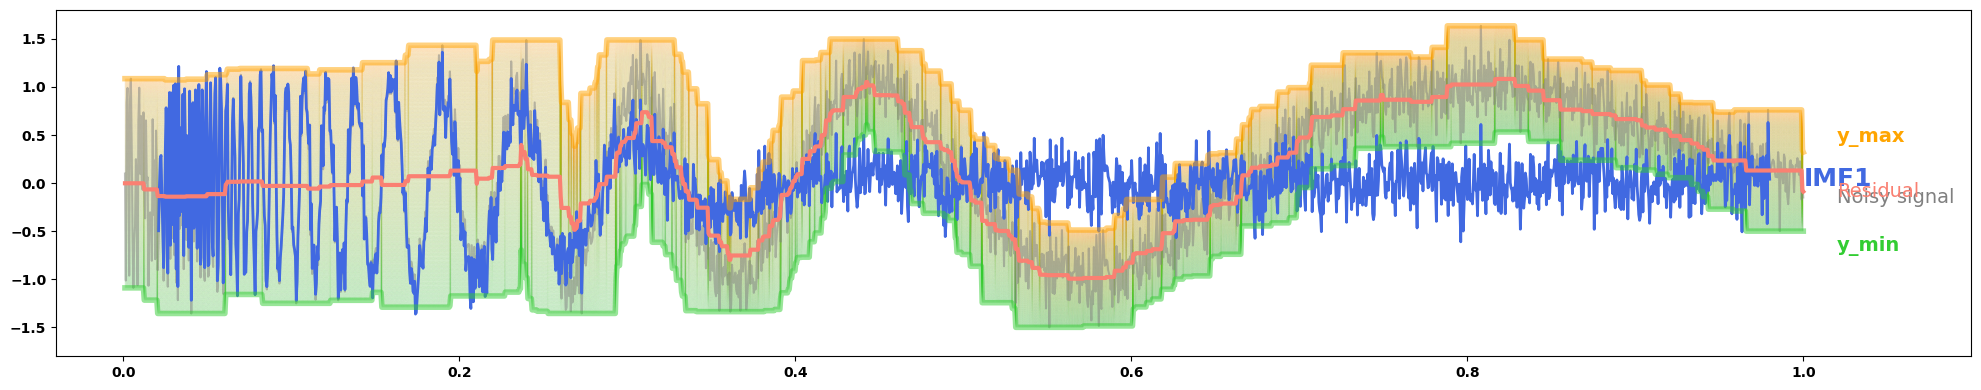

In [67]:
plt.figure(figsize=(20, 4))
ax = plt.gca()

grad_cm = LinearSegmentedColormap.from_list("grad", ["orange", "limegreen"], N=256)
n_levels = 200
mask = np.isfinite(x) & np.isfinite(y_min) & np.isfinite(y_max)
x2 = x[mask]
ymin2 = y_min[mask]
ymax2 = y_max[mask]

t = np.linspace(0, 1, n_levels)[:, None]
X = np.tile(x2[None, :], (n_levels, 1))
Y = (1 - t) * ymax2[None, :] + t * ymin2[None, :]
C = np.tile(t, (1, x2.size))
ax.pcolormesh(X, Y, C, cmap=grad_cm, shading='gouraud', zorder=0.5, alpha=0.04)


plt.plot(x, y_noisy, label=f"Noisy sin(2π/x), noise={noise_std}", color='gray', alpha=0.5)
plt.plot(x, IMF1, label="IMF1 = noisy - envelope", color='royalblue', linewidth=2, alpha=1.0)
plt.plot(x, residual, label="Residual (envelope)", color='salmon', linewidth=3, alpha=1.0)
plt.plot(x, y_max, color='orange', linewidth=4, alpha=0.5)
plt.plot(x, y_min, color='limegreen', linewidth=4, alpha=0.5)

x_end = x[np.isfinite(x)][-1]
dx = 0.02 * (x_end - x[np.isfinite(x)][0])

m = np.isfinite(x) & np.isfinite(y_noisy)
ax.text(x[m][-1] + dx, y_noisy[m][-1], "Noisy signal", color="gray", fontsize=14, va="center")

m = np.isfinite(x) & np.isfinite(IMF1)
ax.text(x[m][-1] + dx, IMF1[m][-1], "IMF1", color="royalblue", fontsize=18, fontweight='bold', va="center")

m = np.isfinite(x) & np.isfinite(residual)
ax.text(x[m][-1] + dx, residual[m][-1], "Residual", color="salmon", fontsize=14, va="center")

m = np.isfinite(x) & np.isfinite(y_max)
ax.text(x[m][-1] + dx, y_max[m][-1]+0.15, "y_max", color="orange", fontsize=14, fontweight='bold', va="center")

m = np.isfinite(x) & np.isfinite(y_min)
ax.text(x[m][-1] + dx, y_min[m][-1]-0.15, "y_min", color="limegreen", fontsize=14, fontweight='bold', va="center")


plt.xlim(-0.04, 1.10)
plt.ylim(-1.8, 1.8)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig("EMD.png", dpi=144, transparent=True)
plt.show()


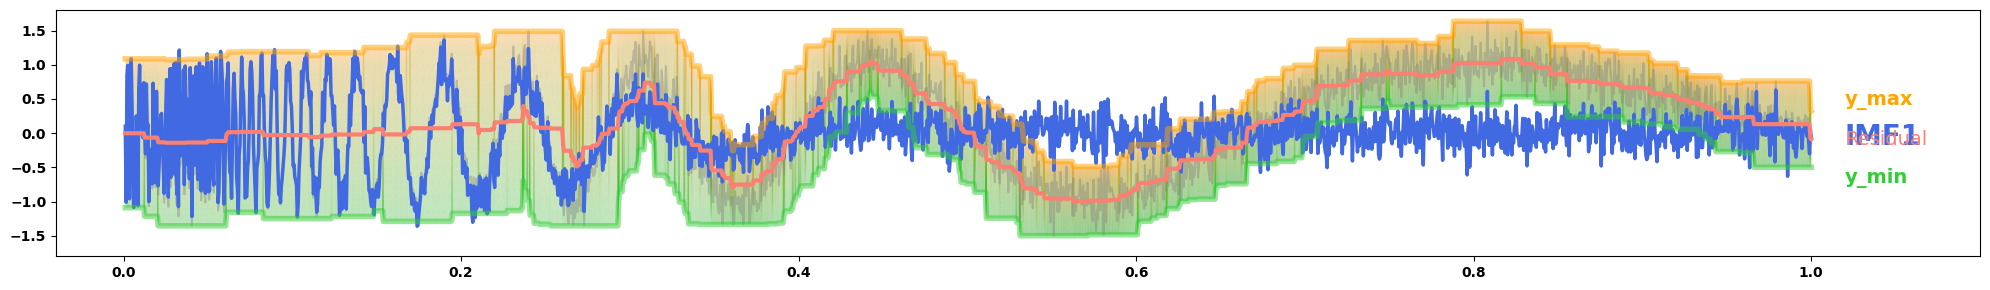

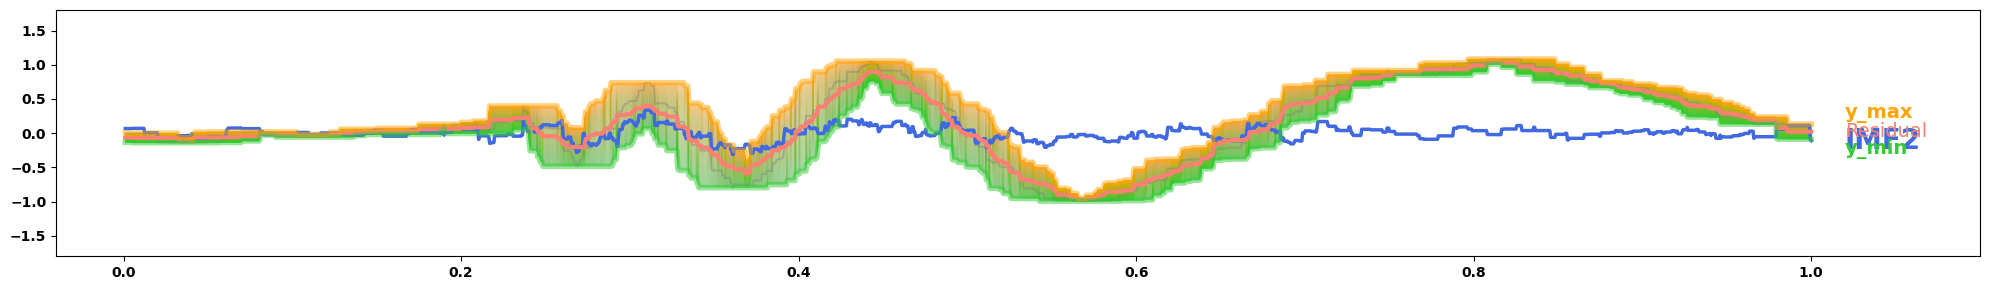

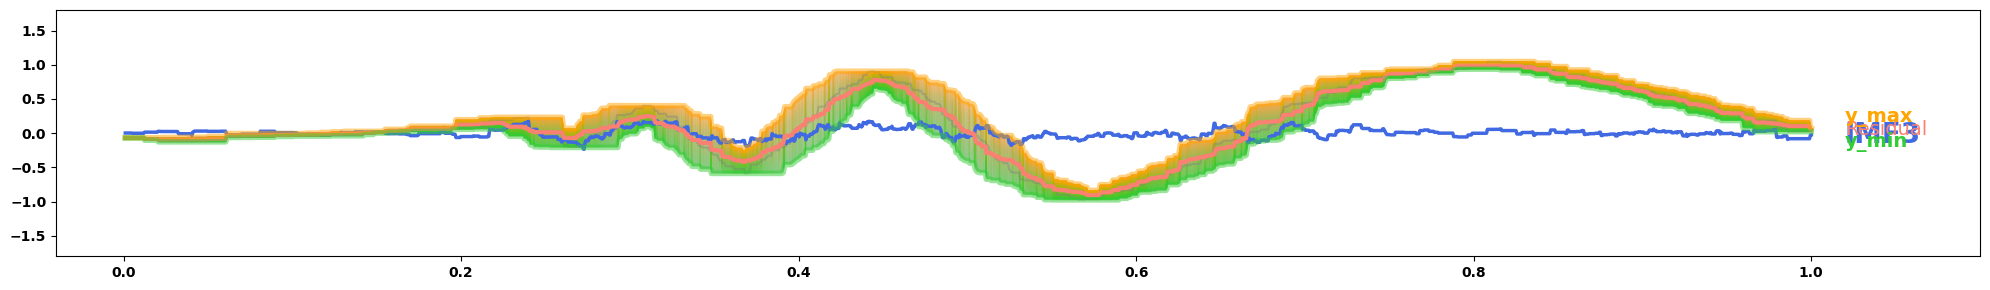

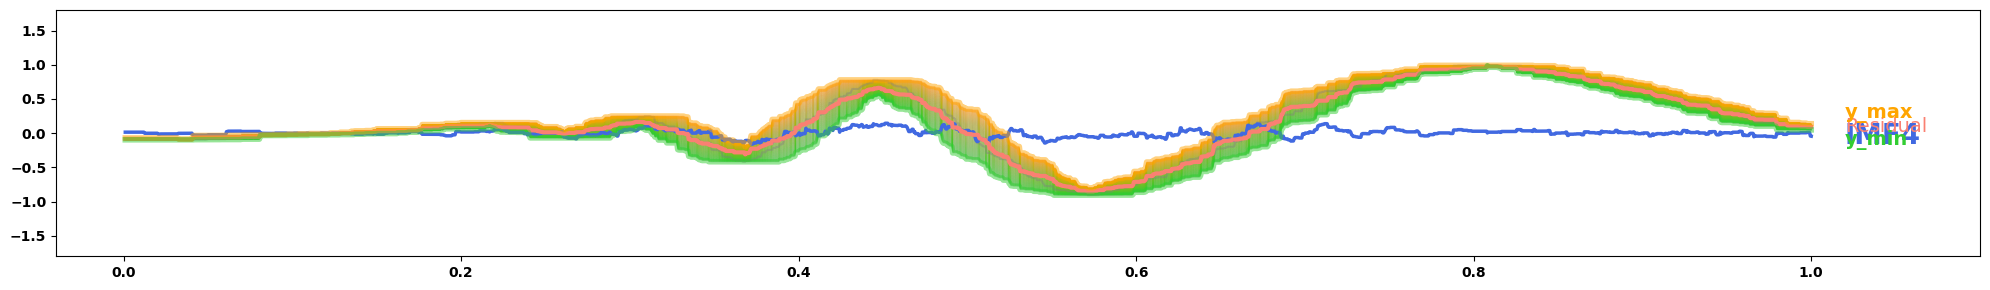

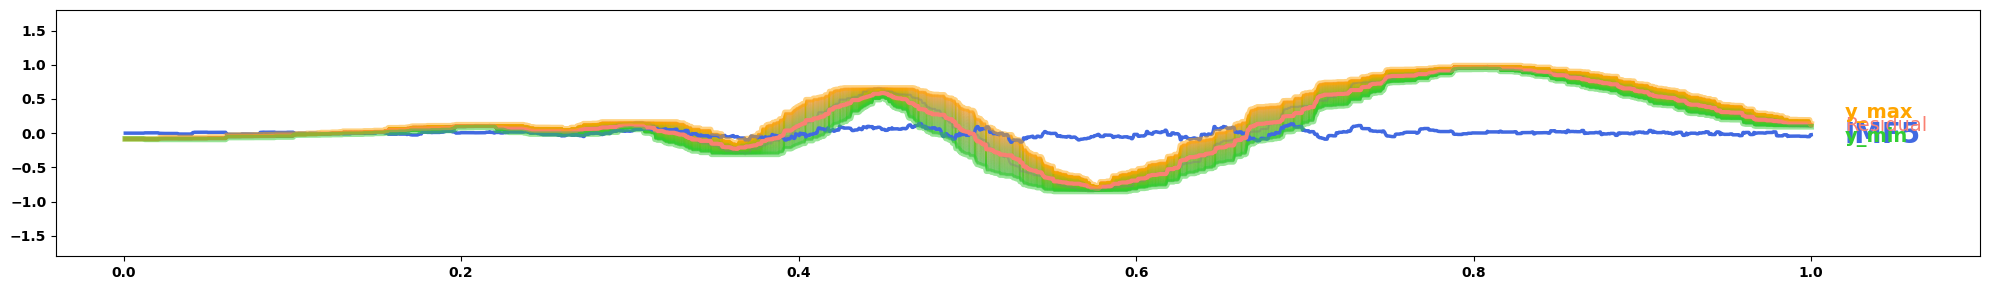

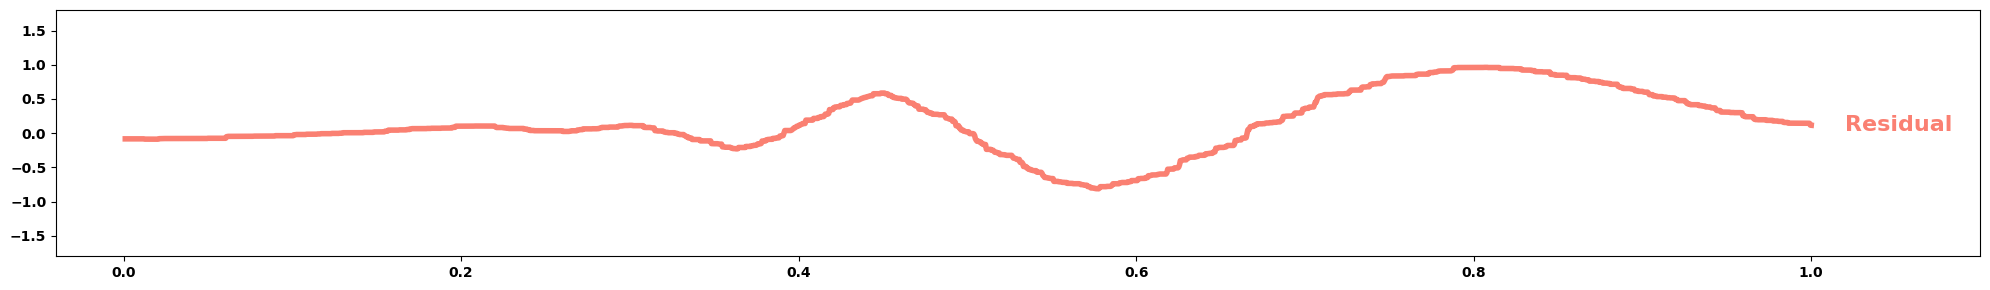

In [69]:
y_current = y_noisy.copy()

for k in range(1, 6):

    y_series = pd.Series(y_current)
    y_max = y_series.rolling(window=window_points, center=True, min_periods=1).max().to_numpy()
    y_min = y_series.rolling(window=window_points, center=True, min_periods=1).min().to_numpy()

    envelope = 0.5 * (y_max + y_min)
    IMFk = y_current - envelope
    residual = envelope

    plt.figure(figsize=(20, 3))
    ax = plt.gca()

    grad_cm = LinearSegmentedColormap.from_list("grad", ["orange", "limegreen"], N=256)
    n_levels = 200

    mask = np.isfinite(x) & np.isfinite(y_min) & np.isfinite(y_max)
    x2 = x[mask]
    ymin2 = y_min[mask]
    ymax2 = y_max[mask]

    t = np.linspace(0, 1, n_levels)[:, None]
    X = np.tile(x2[None, :], (n_levels, 1))
    Y = (1 - t) * ymax2[None, :] + t * ymin2[None, :]
    C = np.tile(t, (1, x2.size))

    ax.pcolormesh(X, Y, C, cmap=grad_cm, shading='gouraud', zorder=0.5, alpha=0.04)

    plt.plot(x, y_current, color='gray', alpha=0.4)
    plt.plot(x, IMFk, color='royalblue', linewidth=2.5)
    plt.plot(x, residual, color='salmon', linewidth=3)
    plt.plot(x, y_max, color='orange', linewidth=4, alpha=0.5)
    plt.plot(x, y_min, color='limegreen', linewidth=4, alpha=0.5)

    x_end = x[np.isfinite(x)][-1]
    dx_txt = 0.02 * (x_end - x[np.isfinite(x)][0])

    m = np.isfinite(x) & np.isfinite(IMFk)
    ax.text(x[m][-1] + dx_txt, IMFk[m][-1], f"IMF{k}", color="royalblue", fontsize=20, fontweight='heavy', va="center")

    m = np.isfinite(x) & np.isfinite(residual)
    ax.text(x[m][-1] + dx_txt, residual[m][-1], "Residual", color="salmon", fontsize=14, va="center")

    m = np.isfinite(x) & np.isfinite(y_max)
    ax.text(x[m][-1] + dx_txt, y_max[m][-1] + 0.15, "y_max", color="orange", fontsize=14, fontweight='bold', va="center")

    m = np.isfinite(x) & np.isfinite(y_min)
    ax.text(x[m][-1] + dx_txt, y_min[m][-1] - 0.15, "y_min", color="limegreen", fontsize=14, fontweight='bold', va="center")

    plt.xlim(-0.04, 1.10)
    plt.ylim(-1.8, 1.8)
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"EMD_iter_{k}.png", dpi=144, transparent=True)
    plt.show()

    y_current = residual.copy()


plt.figure(figsize=(20, 3))
ax = plt.gca()
plt.plot(x, y_current, color='salmon', linewidth=4)

m = np.isfinite(x) & np.isfinite(residual)
ax.text(x[m][-1] + dx_txt, residual[m][-1], "Residual", color="salmon", fontsize=16, fontweight='heavy', va="center")

plt.xlim(-0.04, 1.10)
plt.ylim(-1.8, 1.8)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig("EMD_final_residual.png", dpi=144, transparent=True)
plt.show()



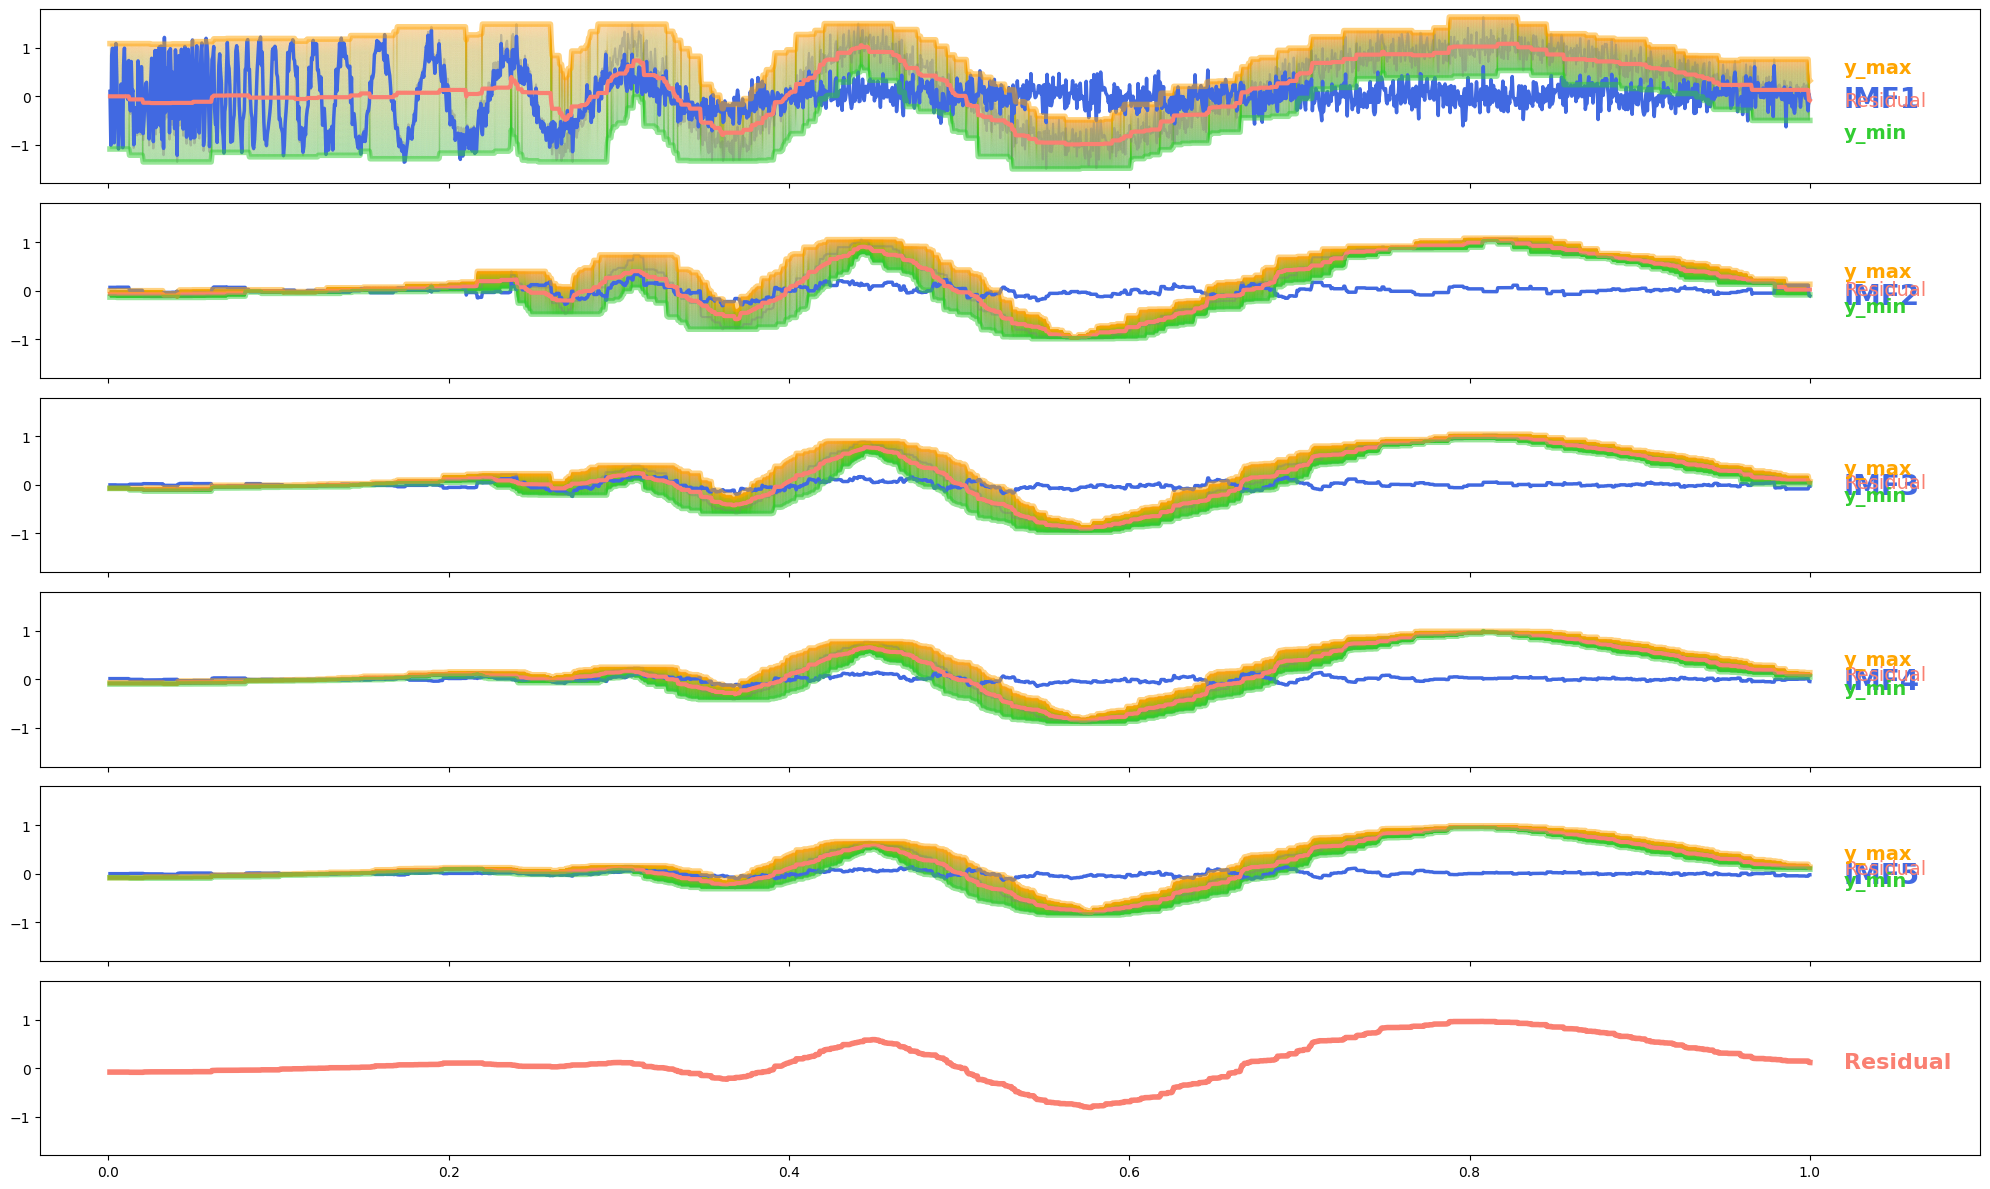

In [71]:
fig, axes = plt.subplots(6, 1, figsize=(20, 12), sharex=True)

y_current = y_noisy.copy()

for k in range(1, 6):

    ax = axes[k-1]

    y_series = pd.Series(y_current)
    y_max = y_series.rolling(window=window_points, center=True, min_periods=1).max().to_numpy()
    y_min = y_series.rolling(window=window_points, center=True, min_periods=1).min().to_numpy()

    envelope = 0.5 * (y_max + y_min)
    IMFk = y_current - envelope
    residual = envelope

    grad_cm = LinearSegmentedColormap.from_list("grad", ["orange", "limegreen"], N=256)
    n_levels = 200

    mask = np.isfinite(x) & np.isfinite(y_min) & np.isfinite(y_max)
    x2 = x[mask]
    ymin2 = y_min[mask]
    ymax2 = y_max[mask]

    t = np.linspace(0, 1, n_levels)[:, None]
    X = np.tile(x2[None, :], (n_levels, 1))
    Y = (1 - t) * ymax2[None, :] + t * ymin2[None, :]
    C = np.tile(t, (1, x2.size))

    ax.pcolormesh(X, Y, C, cmap=grad_cm, shading='gouraud', zorder=0.5, alpha=0.04)

    ax.plot(x, y_current, color='gray', alpha=0.4)
    ax.plot(x, IMFk, color='royalblue', linewidth=2.5)
    ax.plot(x, residual, color='salmon', linewidth=3)
    ax.plot(x, y_max, color='orange', linewidth=4, alpha=0.5)
    ax.plot(x, y_min, color='limegreen', linewidth=4, alpha=0.5)

    x_end = x[np.isfinite(x)][-1]
    dx_txt = 0.02 * (x_end - x[np.isfinite(x)][0])

    m = np.isfinite(x) & np.isfinite(IMFk)
    ax.text(x[m][-1] + dx_txt, IMFk[m][-1], f"IMF{k}", color="royalblue", fontsize=20, fontweight='heavy', va="center")

    m = np.isfinite(x) & np.isfinite(residual)
    ax.text(x[m][-1] + dx_txt, residual[m][-1], "Residual", color="salmon", fontsize=14, va="center")

    m = np.isfinite(x) & np.isfinite(y_max)
    ax.text(x[m][-1] + dx_txt, y_max[m][-1] + 0.25, "y_max", color="orange", fontsize=14, fontweight='bold', va="center")

    m = np.isfinite(x) & np.isfinite(y_min)
    ax.text(x[m][-1] + dx_txt, y_min[m][-1] - 0.25, "y_min", color="limegreen", fontsize=14, fontweight='bold', va="center")

    ax.set_xlim(-0.04, 1.10)
    ax.set_ylim(-1.8, 1.8)
    ax.tick_params(labelsize=10)

    y_current = residual.copy()

ax = axes[5]
ax.plot(x, y_current, color='salmon', linewidth=4)

m = np.isfinite(x) & np.isfinite(y_current)
ax.text(x[m][-1] + dx_txt, y_current[m][-1], "Residual", color="salmon", fontsize=16, fontweight='heavy', va="center")

ax.set_xlim(-0.04, 1.10)
ax.set_ylim(-1.8, 1.8)
ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("EMD_Full.png", dpi=144, transparent=True)
plt.show()


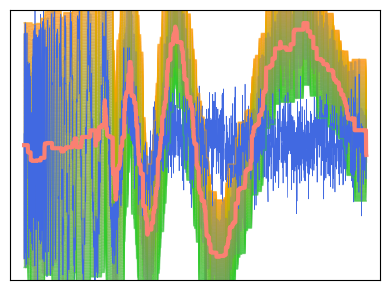

In [70]:
y_current = y_noisy.copy()

for k in range(1, 2):

    y_series = pd.Series(y_current)
    y_max = y_series.rolling(window=window_points, center=True, min_periods=1).max().to_numpy()
    y_min = y_series.rolling(window=window_points, center=True, min_periods=1).min().to_numpy()

    envelope = 0.5 * (y_max + y_min)
    IMFk = y_current - envelope
    residual = envelope

    plt.figure(figsize=(4, 3))
    ax = plt.gca()

    grad_cm = LinearSegmentedColormap.from_list("grad", ["orange", "limegreen"], N=256)
    n_levels = 200

    mask = np.isfinite(x) & np.isfinite(y_min) & np.isfinite(y_max)
    x2 = x[mask]
    ymin2 = y_min[mask]
    ymax2 = y_max[mask]

    t = np.linspace(0, 1, n_levels)[:, None]
    X = np.tile(x2[None, :], (n_levels, 1))
    Y = (1 - t) * ymax2[None, :] + t * ymin2[None, :]
    C = np.tile(t, (1, x2.size))

    ax.pcolormesh(X, Y, C, cmap=grad_cm, shading='gouraud', zorder=0.5, alpha=0.04)

    plt.plot(x, y_current, color='gray', alpha=0.4)
    plt.plot(x, IMFk, color='royalblue', linewidth=0.5)
    plt.plot(x, residual, color='salmon', linewidth=3)
    plt.plot(x, y_max, color='orange', linewidth=1, alpha=0.5)
    plt.plot(x, y_min, color='limegreen', linewidth=1, alpha=0.5)

    plt.xlim(-0.04, 1.04)
    plt.ylim(-1.2, 1.2)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.savefig(f"EMD_Slides_Logo.png", dpi=144, transparent=True)
    plt.show()

    y_current = residual.copy()